# Dataset Link
https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

# Data Description
## Context
The original dataset cotains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
- Risk (Value target - Good or Bad Risk)


## Libraries 


In [78]:
#visulaization and DataFrame tool
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Adding Pandas Profiling for Data Summarization
import ydata_profiling
from ydata_profiling import ProfileReport
#For Standardisation of Data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#For One Hot Encoding of Data
from sklearn.preprocessing import LabelEncoder
#For train test split
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                       
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score    
#Balancing Number of Training Observations
from imblearn.over_sampling import SMOTE
#Pipeline for feature Selection
from sklearn.pipeline import Pipeline
# Models used for analyis and comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats.mstats import winsorize
#Feature Slection and Classification Report
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.metrics import confusion_matrix, classification_report

import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)



# 2. Exploratory Data Analysis 

## 2.1 Reading Data 

In [3]:
Credit = pd.read_csv("german_credit_data.csv", index_col=0)

## 2.2 Loading head of Data Set

In [4]:
#Loading first five entries of the dataset
Credit.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## 2.3 Dimension of the Data Set

In [5]:
Credit.shape

(1000, 10)

## 2.4 Summary of Data 

### We use Pandas Profiling for Data Summary

In [6]:
profile = ProfileReport(Credit, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Clearly using Profiling is hepful since we get 
1) The Description of every variable starting from it's type to unique category to number of observations to plots , head and tail of dataset etc.
2) The Number of missing observations or values of a particular feature
3) The scatterplot of every numerical variable with each other 

## 2.5 Dealing with missing values 

In [7]:
Credit.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Since from profilling we know Savings Account and Checking Account are categorical variables , hence we can only impute the missing values with mode 

In [8]:
#Filling missing values 
Credit['Saving accounts'].fillna(Credit['Saving accounts'].mode()[0], inplace=True)
Credit['Checking account'].fillna(Credit['Checking account'].mode()[0], inplace=True)

In [9]:
Credit.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

### We encode Risk and sex column since they are a binary variable 

In [10]:
# Define a mapping dictionary
Sex_map = {'male': 0, 'female': 1}

# Use map to apply the mapping to the 'sex' column
Credit['sex_encoded'] = Credit['Sex'].map(Sex_map)
Credit['sex_encoded']=Credit['sex_encoded'].astype(int)

In [11]:
# Define a mapping dictionary
Risk_map = {'good': 0, 'bad': 1}

# Use map to apply the mapping to the 'sex' column
Credit['Risk_encoded'] = Credit['Risk'].map(Risk_map)
#Finally we multiply Health['sex_encoded'] variable with bmi to find a differential impact
Credit['Risk_encoded']=Credit['Risk_encoded'].astype(int)

## 2.6 Analysing the Relationship between Numerical Variables 

### 2.6.1 We start with the correlation matrix 

In [12]:
#Filtering out only the numeric variables from the dataframe
Numeric_columns_of_Credit = Credit.select_dtypes(include=['number'])
#Making a dataframe out of it
Numeric_columns_of_Credit = pd.DataFrame(Numeric_columns_of_Credit)
Numeric_columns_of_Credit

,Age,Job,Credit amount,Duration,sex_encoded,Risk_encoded
0,67,2,1169,6,0,0
1,22,2,5951,48,1,1
2,49,1,2096,12,0,0
3,45,2,7882,42,0,0
4,53,2,4870,24,0,1
...,...,...,...,...,...,...
995,31,1,1736,12,1,0
996,40,3,3857,30,0,0
997,38,2,804,12,0,0
998,23,2,1845,45,0,1


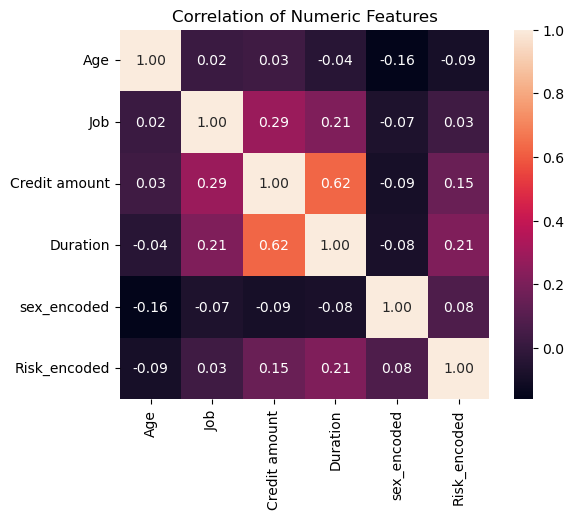

In [13]:
#Printing out the correlation matrix
sns.heatmap(Numeric_columns_of_Credit.corr(),annot=True, fmt='.2f', square=True)
plt.title('Correlation of Numeric Features')
plt.show()

### One important feature of the matrix is though all the features have a very low correlation, Credit Amount and Duration have a high correlation which might imply if people have a high amount most of the times it might imply loan amount is large as well

### 2.6.2 We start with histplot

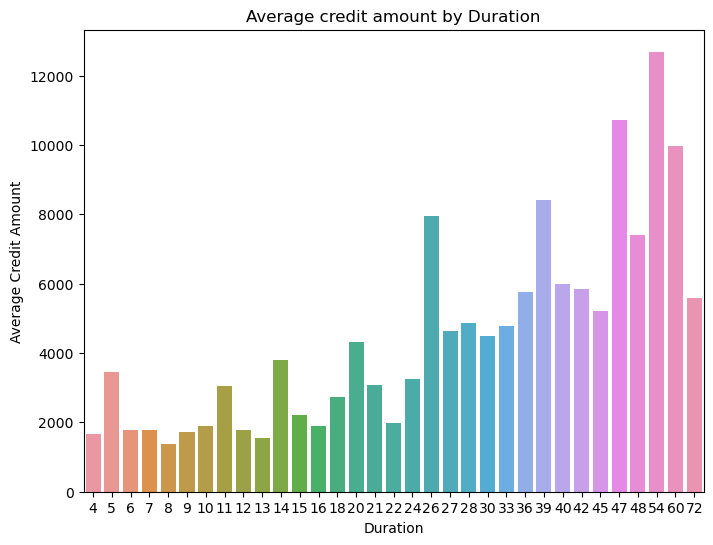

In [14]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Duration', y='Credit amount', data=Credit, estimator=lambda x: sum(x) / len(x), ci=None)
plt.title('Average credit amount by Duration')
plt.xlabel('Duration')
plt.ylabel('Average Credit Amount')
plt.show()

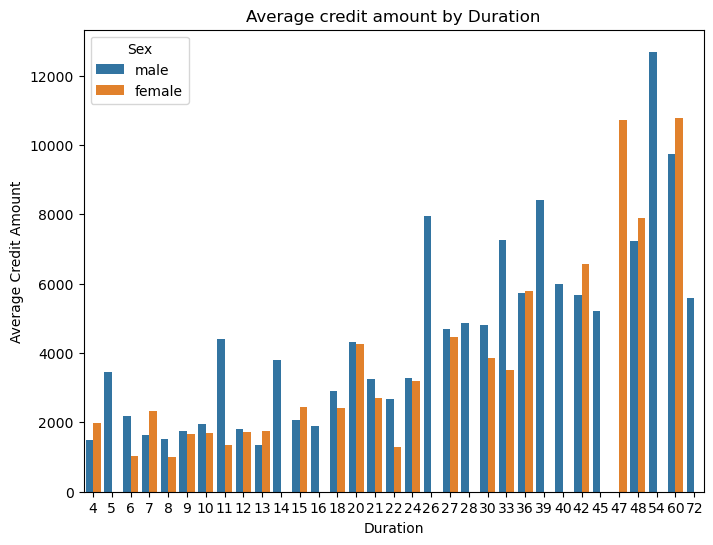

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Duration', y='Credit amount', data=Credit, estimator=lambda x: sum(x) / len(x), ci=None,hue=Credit['Sex'])
plt.title('Average credit amount by Duration')
plt.xlabel('Duration')
plt.ylabel('Average Credit Amount')
plt.show()

### Clearly with lower duration Males have a higher claim amount but as durations increase female have a higher claim amount

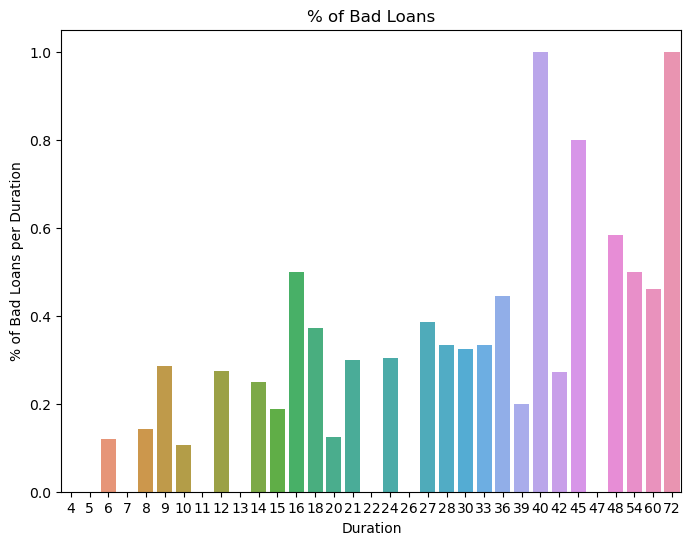

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Duration', y='Risk_encoded', data=Credit, estimator=lambda y: sum(y) / len(y), ci=None)
plt.title('% of Bad Loans')
plt.xlabel('Duration')
plt.ylabel('% of Bad Loans per Duration')
plt.show()

### Clearly we have what in finance we called a duration risk, the more the time the loan is taken the greater the percentage of total number of loans going bad

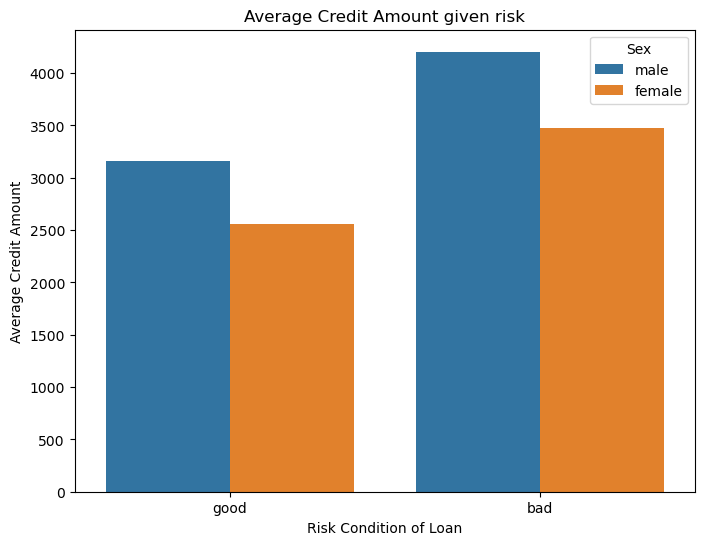

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Risk', y='Credit amount', data=Credit, estimator=lambda y: sum(y) / len(y), hue=Credit['Sex'],ci=None)
plt.title('Average Credit Amount given risk')
plt.xlabel('Risk Condition of Loan')
plt.ylabel('Average Credit Amount')
plt.show()

### Clearly average Credit Amount is higher for bad loans than for good loans and also for both kind of loans male have a higher average credit amount than female respectively

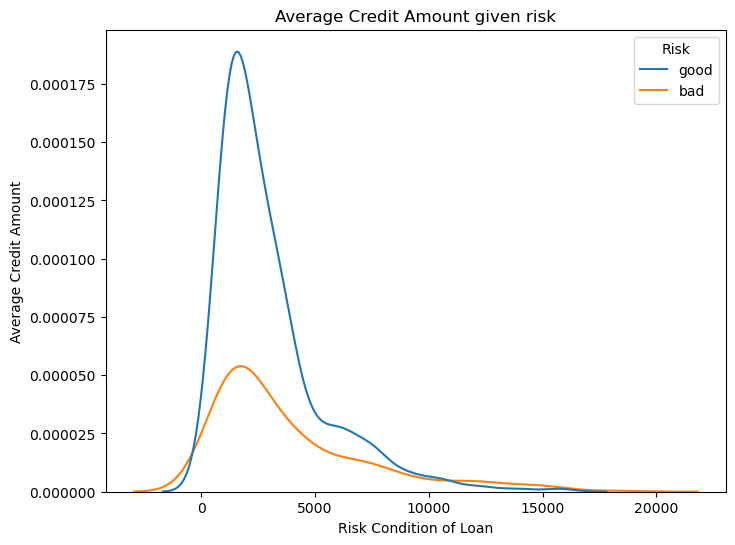

In [18]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x='Credit amount', data=Credit, hue=Credit['Risk'])
plt.title('Average Credit Amount given risk')
plt.xlabel('Risk Condition of Loan')
plt.ylabel('Average Credit Amount')
plt.show()

### Clearly more people have credit amount between 0 to 5000 having good loan status than people having bad loan status in this same interval respectively

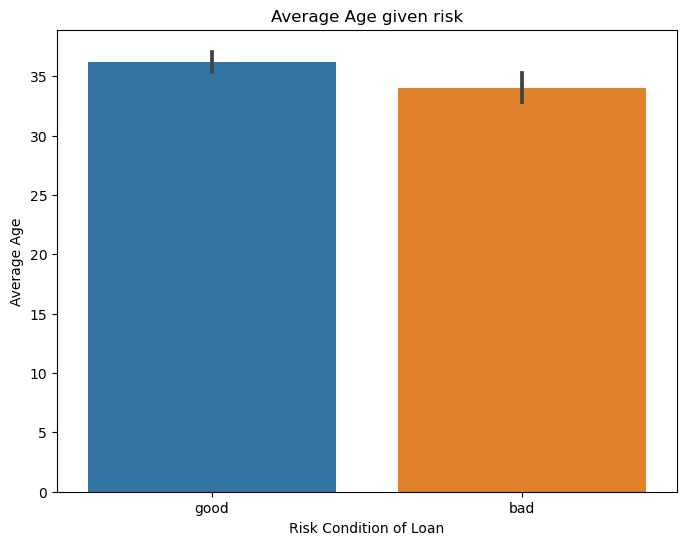

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Risk', y='Age', data=Credit,estimator=lambda y: sum(y) / len(y))
plt.title('Average Age given risk')
plt.xlabel('Risk Condition of Loan')
plt.ylabel('Average Age')
plt.show()

### People who have bad loans or have defaulted have lower average age than people who have good loans and are able to pay back However the defaulters are younger by at max 2 years 

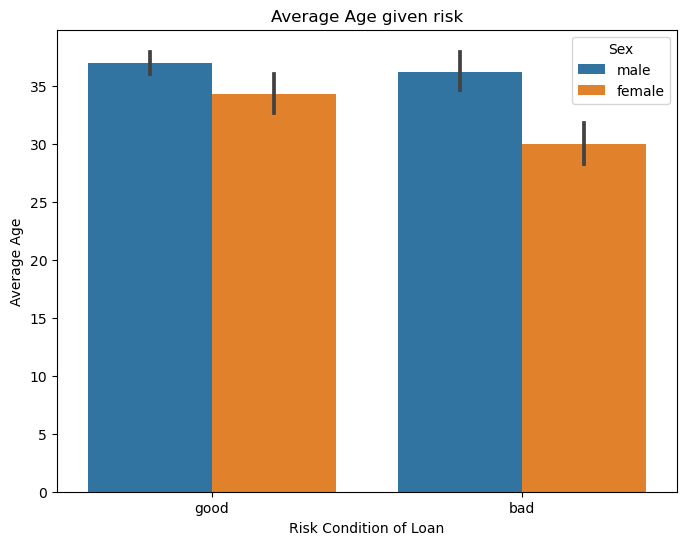

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Risk', y='Age', data=Credit,estimator=lambda y: sum(y) / len(y), hue=Credit['Sex'])
plt.title('Average Age given risk')
plt.xlabel('Risk Condition of Loan')
plt.ylabel('Average Age')
plt.show()

### The Age difference in Loan Payers and loan defaulters are more in Females than in males

In [21]:
#We divide Age into further bins to see better results
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
Credit["Age_cat"] = pd.cut(Credit.Age, interval, labels=cats)


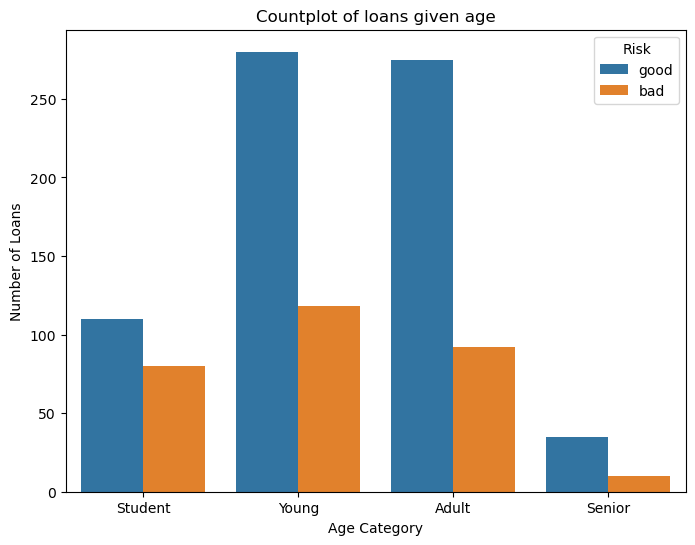

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Age_cat',data=Credit,hue=Credit['Risk'])
plt.title('Countplot of loans given age')
plt.xlabel('Age Category')
plt.ylabel('Number of Loans')
plt.show()

### Clearly Young and Adult aged between 25 to 60 have more of good loans and bad loans than student and senior population 

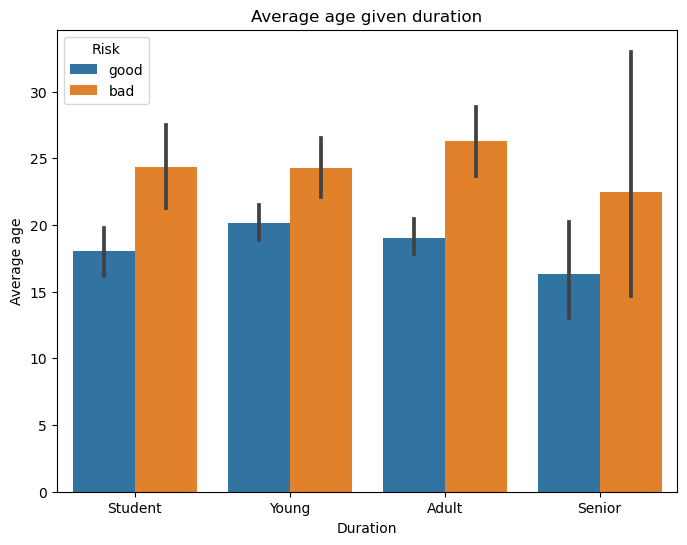

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Age_cat',y='Duration', estimator=lambda y: sum(y) / len(y),data=Credit,hue=Credit['Risk'])
plt.title('Average age given duration')
plt.xlabel('Duration')
plt.ylabel('Average age')
plt.show()

### It can be clearly seen young people people have the highest duration of good loans while Adult people have the highest duration of Bad Loan

## 2.7 Analysis of categorical variables

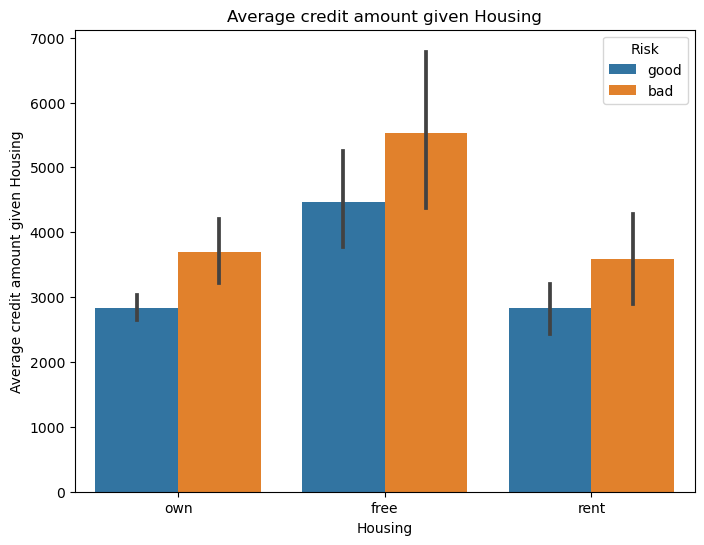

In [24]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Housing',y='Credit amount', estimator=lambda y: sum(y) / len(y),data=Credit,hue=Credit['Risk'])
plt.title('Average credit amount given Housing')
plt.xlabel('Housing')
plt.ylabel('Average credit amount given Housing')
plt.show()

### People who live in Free Houses have maximum Credit amount both in Good and Bad Loans 

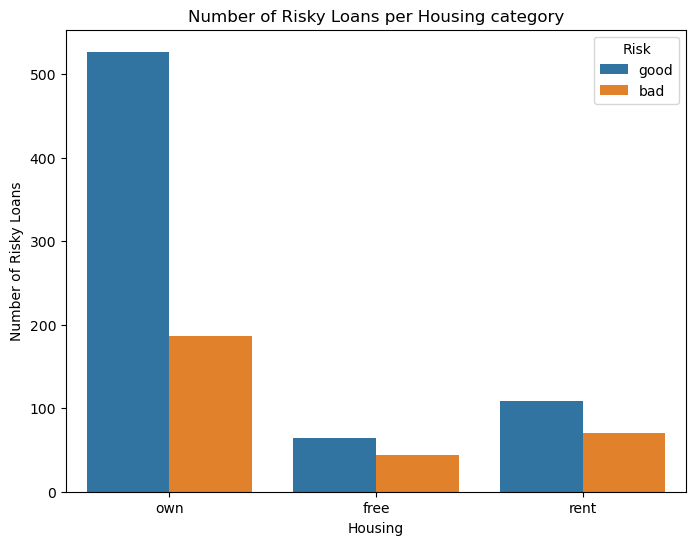

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Housing',data=Credit,hue=Credit['Risk'])
plt.title('Number of Risky Loans per Housing category')
plt.xlabel('Housing')
plt.ylabel('Number of Risky Loans')
plt.show()

### This is a perfect example of credit risk since people who own houses have more of both Good (Non-Risky) Loans and Bad (Risky) Loans since it might imply people who live in own houses borrow money a lot as to finance the development of their house

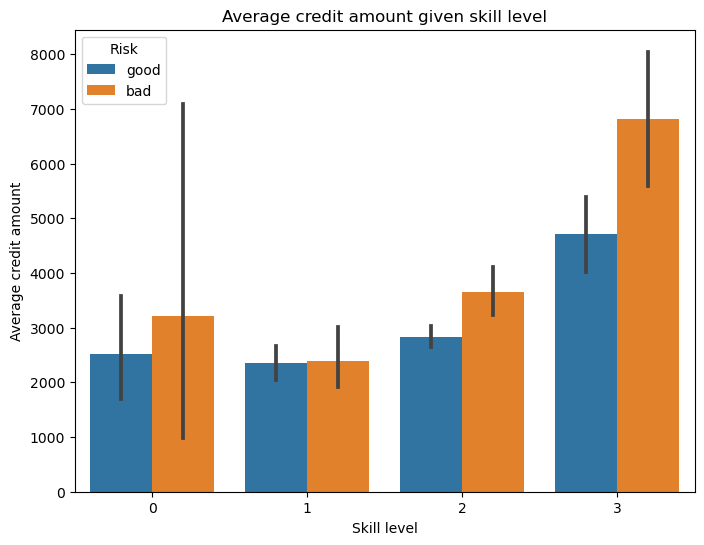

In [26]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Job',y='Credit amount', estimator=lambda y: sum(y) / len(y),data=Credit,hue=Credit['Risk'])
plt.title('Average credit amount given skill level')
plt.xlabel('Skill level')
plt.ylabel('Average credit amount')
plt.show()

### People who are highly skilled takes more credit or loan of both better and worse category while People who are unskilled takes the lowest loan amount

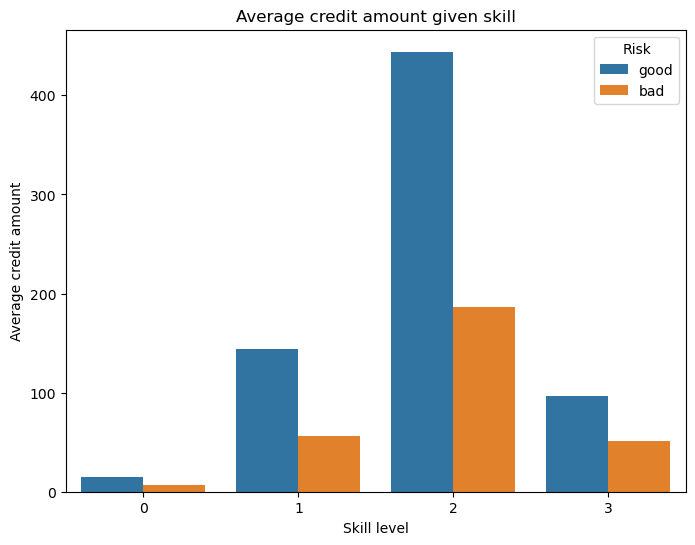

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Job', data=Credit,hue=Credit['Risk'])
plt.title('Average credit amount given skill')
plt.xlabel('Skill level')
plt.ylabel('Average credit amount')
plt.show()

### As it turns out that though people who are highly skilled have more credit amount , people who are just skilled have more number of Good and Bad Loans , Hence the Loan column has such a low correlation with credit amount  

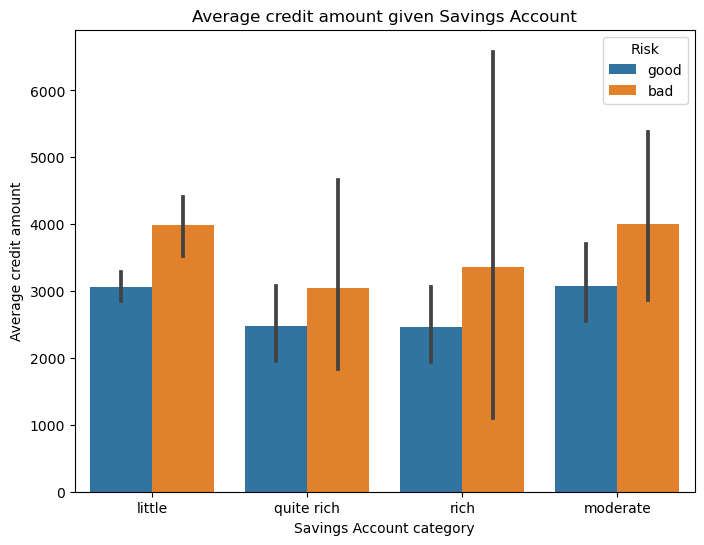

In [28]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Saving accounts',y='Credit amount', estimator=lambda y: sum(y) / len(y),data=Credit,hue=Credit['Risk'])
plt.title('Average credit amount given Savings Account')
plt.xlabel('Savings Account category')
plt.ylabel('Average credit amount')
plt.show()

### People who have low and moderate amount in Savings account have high amount of average Credit Amount 

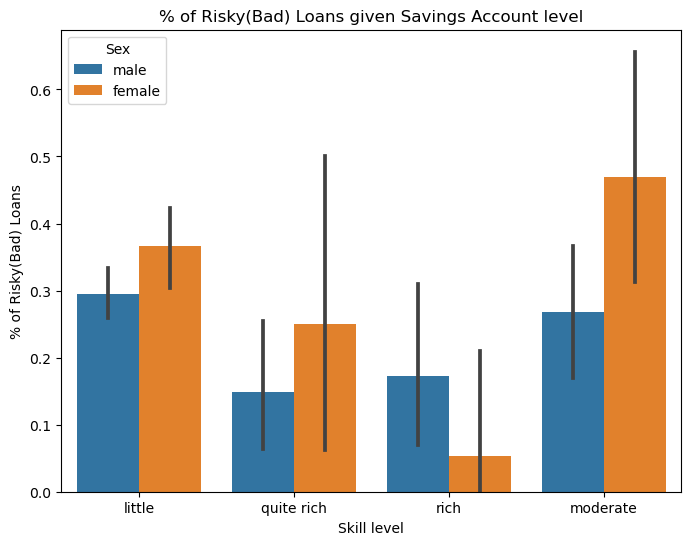

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Saving accounts',y='Risk_encoded',data=Credit,hue=Credit['Sex'])
plt.title('% of Risky(Bad) Loans given Savings Account level')
plt.xlabel('Skill level')
plt.ylabel('% of Risky(Bad) Loans')
plt.show()

### Clearly there are more proportion of bad loans among people with moderate and little savings account balance and the disparity is more in females with 35-50% of them unable to pay back 

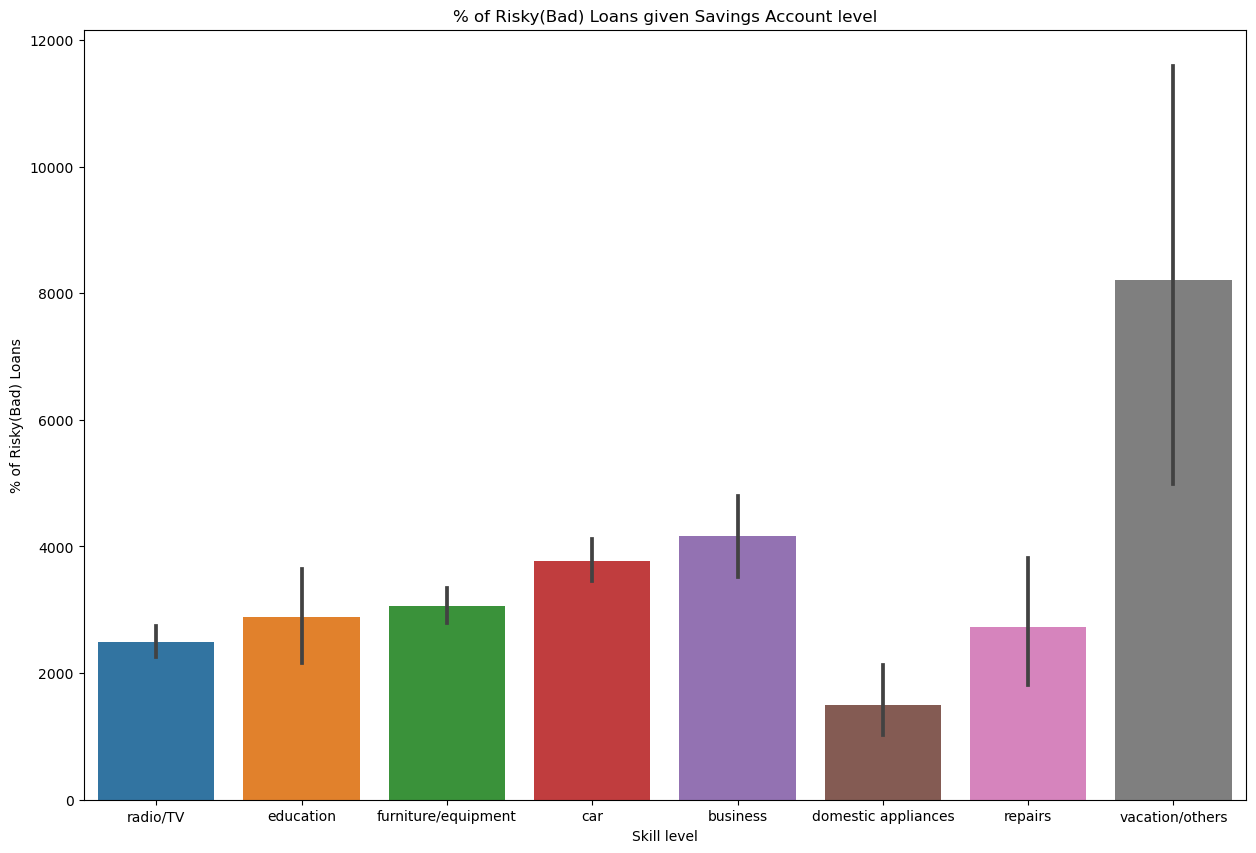

In [30]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Purpose',y='Credit amount',data=Credit)
plt.title('% of Risky(Bad) Loans given Savings Account level')
plt.xlabel('Skill level')
plt.ylabel('% of Risky(Bad) Loans')
plt.show()

### Most of the amount that have been borrowed by an individual is for vacation followed by business and car bying purpose 

## 2.8 Outlier Detection

### 2.8.1 Box Plot of Outliers

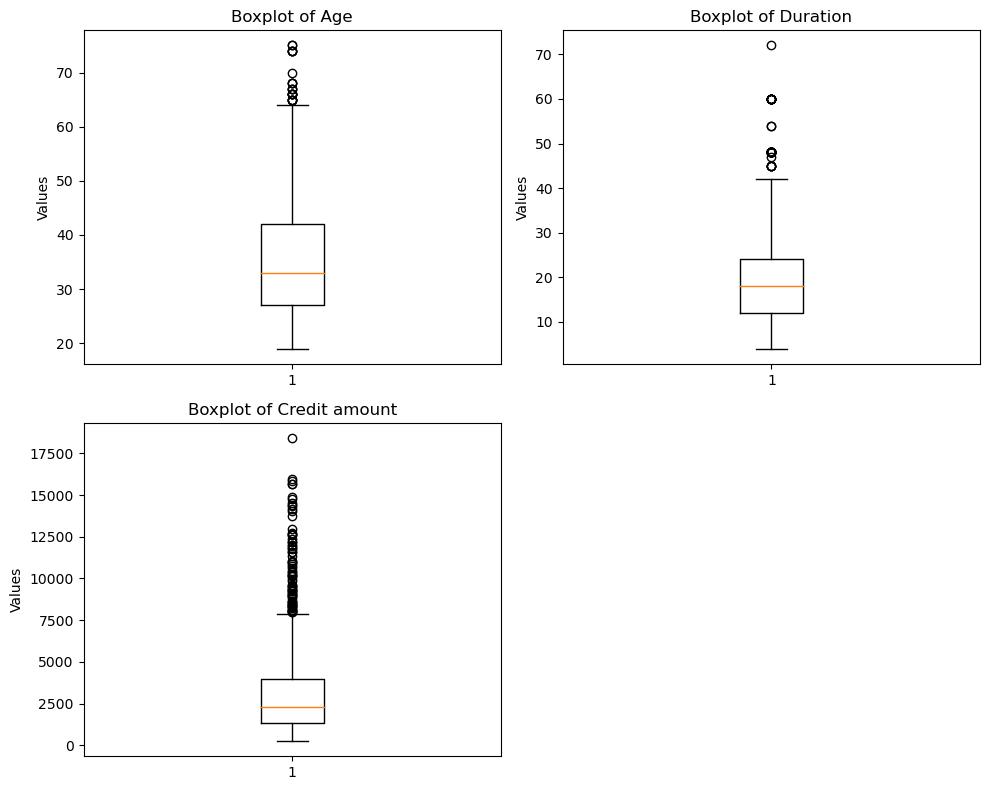

In [31]:
# Select numerical columns only
numerical_columns = Credit[['Age','Duration','Credit amount']]


plt.figure(figsize=(10, 8))

for i, column in enumerate(numerical_columns.columns):
    plt.subplot(len(numerical_columns.columns)//2 + 1, 2, i+1)  # Adjust the layout if necessary
    plt.boxplot(numerical_columns[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

### 2.8.2 Counting the number of outliers

In [32]:
# Function to count outliers using IQR for numerical columns only
def count_outliers_iqr(column):
    if pd.api.types.is_numeric_dtype(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = column[(column < lower_bound) | (column > upper_bound)]
        return outliers.shape[0]
    else:
        return 0  

# Count outliers for each numerical column in Credit
outliers_counts = Credit[['Age','Duration','Credit amount']].apply(count_outliers_iqr)
print("Number of outliers in each numerical column:")
print(outliers_counts)


Number of outliers in each numerical column:
Age              23
Duration         70
Credit amount    72
dtype: int64


### Since we have significantly low number of outliers we need not deal with it as we are going to standardize it as well 

## 2.9 Standardization of numerical data

We first plot the data 

### 2.9.1 Intitial plot of numeric data 

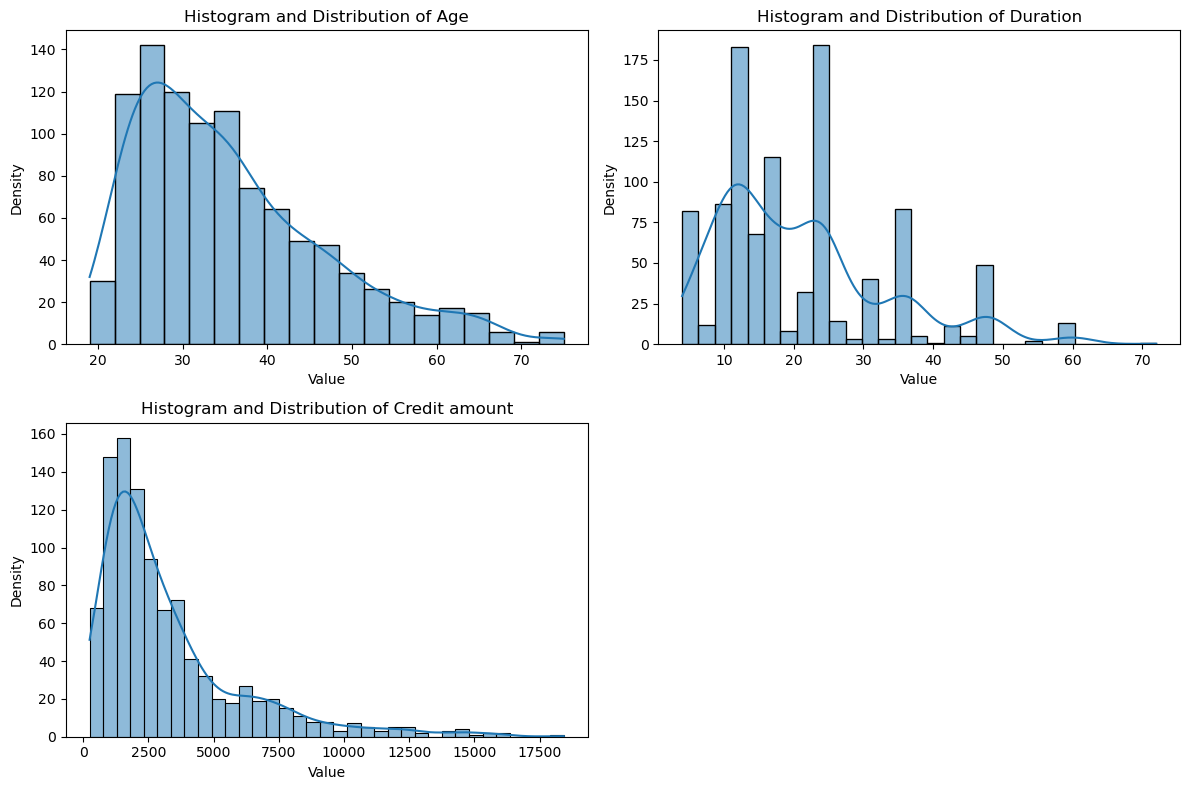

In [33]:
# Plot histograms of each column
plt.figure(figsize=(12, 8))

for i, column in enumerate(numerical_columns.columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(numerical_columns[column],kde=True)  # KDE plot with shading
    plt.title(f'Histogram and Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Clearly our data is positively skewed and hence we have to apply transformation so our data works smoothly

### 2.9.2 Standard Scaler Standardisation

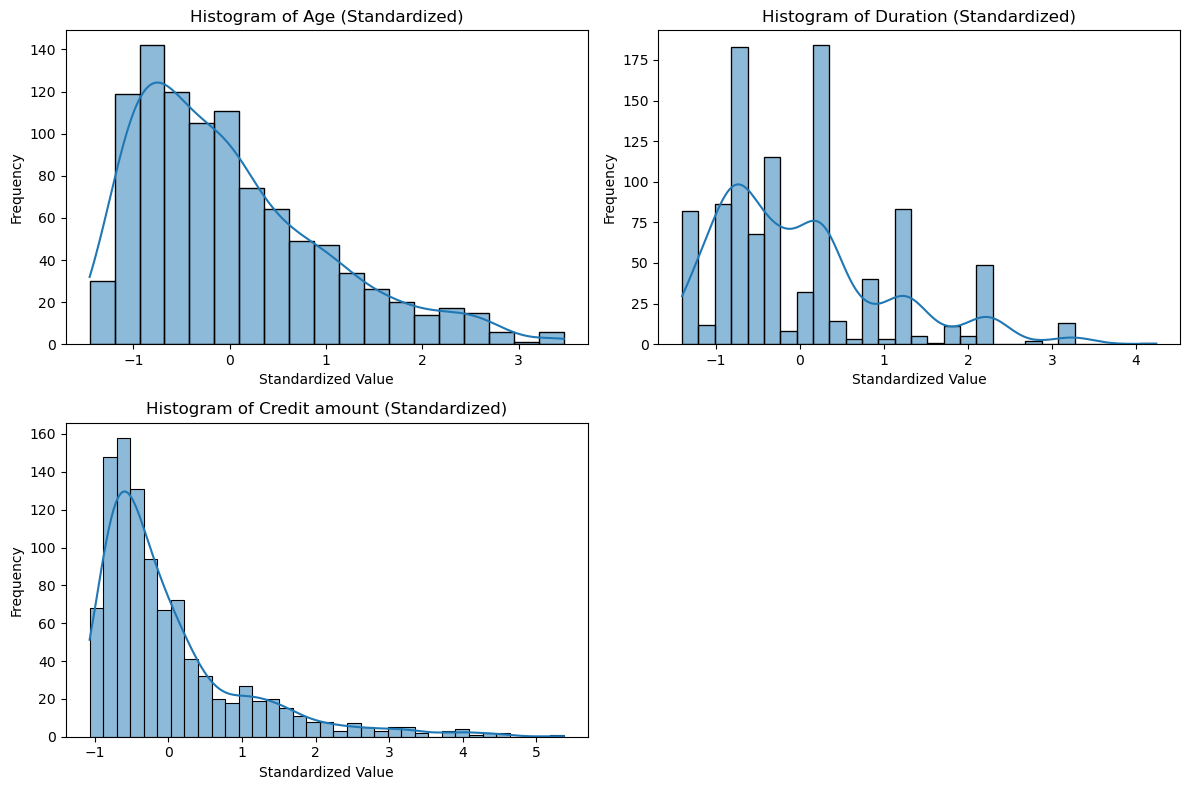

In [34]:
scaler = StandardScaler()
Credit_standardized = pd.DataFrame(scaler.fit_transform(numerical_columns), columns=numerical_columns.columns)

# Plot histograms of each standardized column
plt.figure(figsize=(12, 8))

for i, column in enumerate(Credit_standardized.columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(Credit_standardized[column], kde=True)  # Adjust number of bins as needed
    plt.title(f'Histogram of {column} (Standardized)')
    plt.xlabel('Standardized Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### 2.9.3 Min Max Scaler 

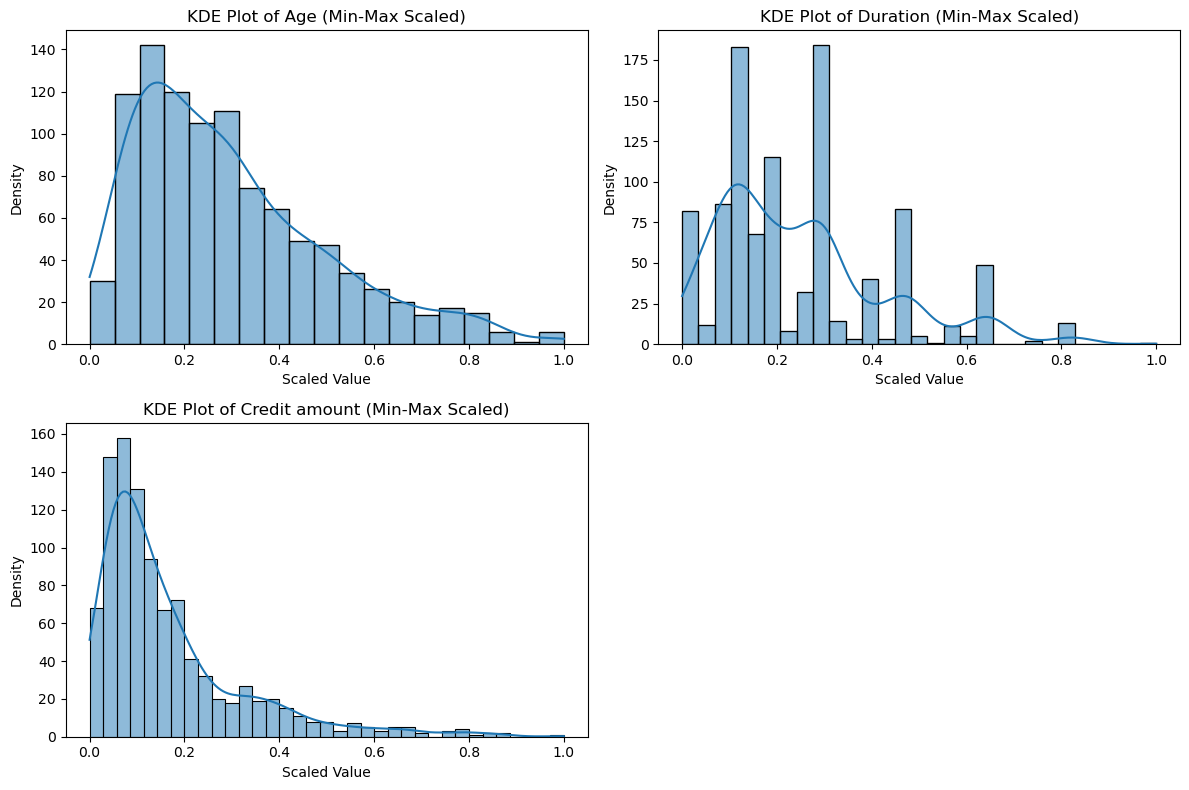

In [35]:
scaler = MinMaxScaler()
Credit_minmax = pd.DataFrame(scaler.fit_transform(numerical_columns), columns=numerical_columns.columns)

# Plot KDE plots of each Min-Max scaled column
plt.figure(figsize=(12, 8))

for i, column in enumerate(Credit_minmax.columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(Credit_minmax[column], kde=True)  # KDE plot with shading
    plt.title(f'KDE Plot of {column} (Min-Max Scaled)')
    plt.xlabel('Scaled Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### 2.9.4 Robust Scaling

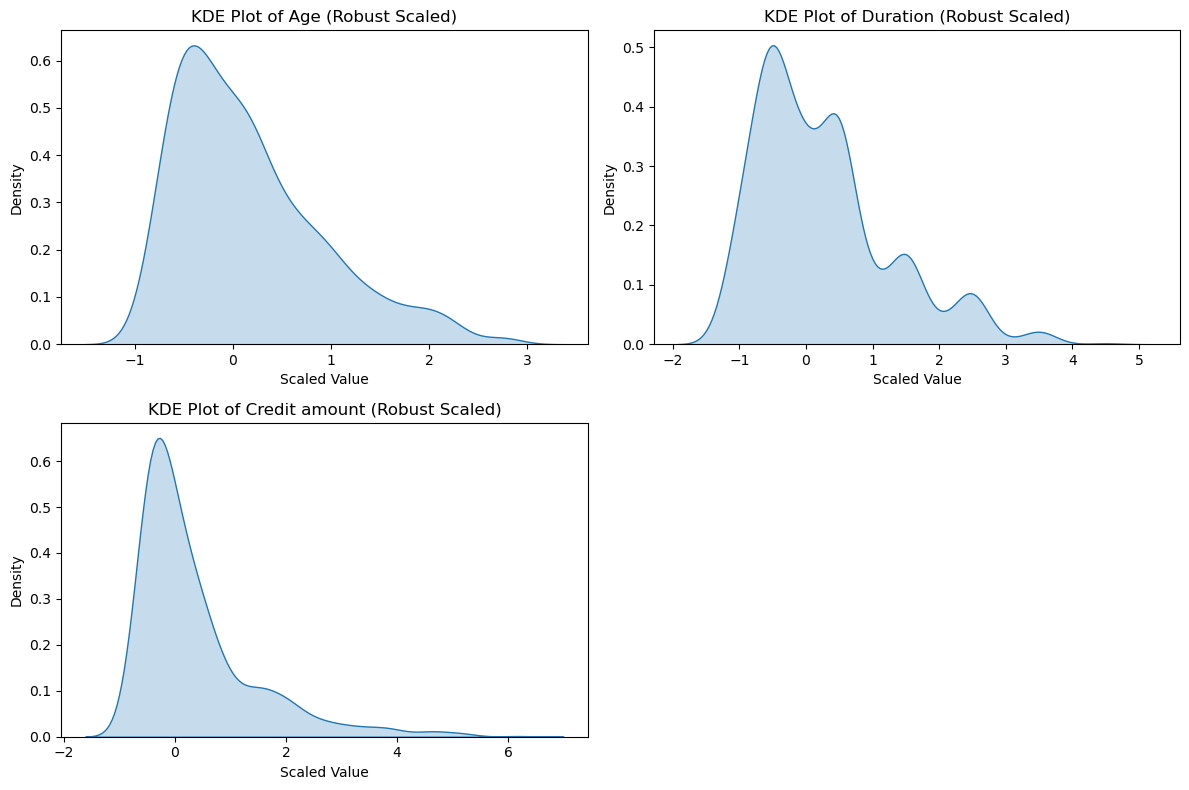

In [36]:
# Robust scaling each column
scaler = RobustScaler()
Credit_robust = pd.DataFrame(scaler.fit_transform(numerical_columns), columns=numerical_columns.columns)

# Plot KDE plots of each Robust scaled column
plt.figure(figsize=(12, 8))

for i, column in enumerate(Credit_robust.columns, start=1):
    plt.subplot(2, 2, i)
    sns.kdeplot(Credit_robust[column], shade=True)  # KDE plot with shading
    plt.title(f'KDE Plot of {column} (Robust Scaled)')
    plt.xlabel('Scaled Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### 2.9.5 Log Transformation

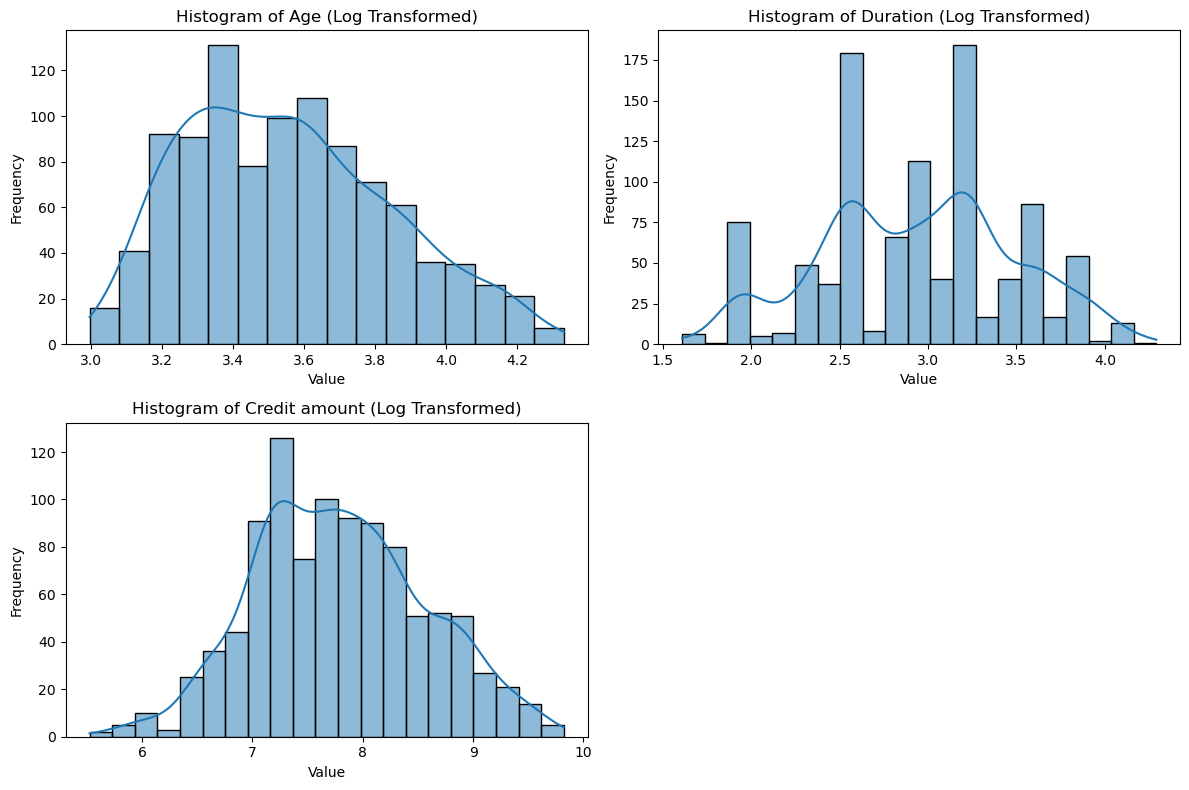

In [37]:
# Apply log transformation
Credit_log = numerical_columns.apply(np.log1p)

# Plot histograms of each log transformed column
plt.figure(figsize=(12, 8))

for i, column in enumerate(Credit_log.columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(Credit_log[column], kde=True)  # Adjust number of bins as needed
    plt.title(f'Histogram of {column} (Log Transformed)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Clearly Log Transformation of Data normalises it , so we replace the numeric data with Log Normal of the Numeric data

In [38]:
Credit[['Age','Duration','Credit amount']] = Credit_log

In [39]:
Credit

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,sex_encoded,Risk_encoded,Age_cat
0,4.219508,male,2,own,little,little,7.064759,1.945910,radio/TV,good,0,0,Senior
1,3.135494,female,2,own,little,moderate,8.691483,3.891820,radio/TV,bad,1,1,Student
2,3.912023,male,1,own,little,little,7.648263,2.564949,education,good,0,0,Adult
3,3.828641,male,2,free,little,little,8.972464,3.761200,furniture/equipment,good,0,0,Adult
4,3.988984,male,2,free,little,little,8.491055,3.218876,car,bad,0,1,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.465736,female,1,own,little,little,7.459915,2.564949,furniture/equipment,good,1,0,Young
996,3.713572,male,3,own,little,little,8.257904,3.433987,car,good,0,0,Adult
997,3.663562,male,2,own,little,little,6.690842,2.564949,radio/TV,good,0,0,Adult
998,3.178054,male,2,free,little,little,7.520776,3.828641,radio/TV,bad,0,1,Student


## 3.0 Encoding of Categorical Variables

### 3.0.1 We will do one hot encoding of Housing since it has 3 classes and not an ordinal variable

We first convert class of Categorical Variables from object to categoric 

In [40]:
Credit[['Housing','Saving accounts','Checking account','Purpose']] = Credit[['Housing','Saving accounts','Checking account','Purpose']].astype('category')

Also since Risk, sex is already one Hot Encoded we drop those two object columns and age Category column since it is not important

In [41]:
Credit.drop(columns=['Risk','Sex','Age_cat'],inplace=True)

One Hot Encoding of Housing Variable

In [42]:
Credit = pd.get_dummies(Credit, columns=['Housing'],drop_first=True)

In [43]:
Credit[['Housing_own','Housing_rent']]=Credit[['Housing_own','Housing_rent']].astype(int)

In [44]:
Credit

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,sex_encoded,Risk_encoded,Housing_own,Housing_rent
0,4.219508,2,little,little,7.064759,1.945910,radio/TV,0,0,1,0
1,3.135494,2,little,moderate,8.691483,3.891820,radio/TV,1,1,1,0
2,3.912023,1,little,little,7.648263,2.564949,education,0,0,1,0
3,3.828641,2,little,little,8.972464,3.761200,furniture/equipment,0,0,0,0
4,3.988984,2,little,little,8.491055,3.218876,car,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,3.465736,1,little,little,7.459915,2.564949,furniture/equipment,1,0,1,0
996,3.713572,3,little,little,8.257904,3.433987,car,0,0,1,0
997,3.663562,2,little,little,6.690842,2.564949,radio/TV,0,0,1,0
998,3.178054,2,little,little,7.520776,3.828641,radio/TV,0,1,0,0


### 3.0.2 We then do OHE of Purpose variable since it is not ordinal as well

In [45]:
Credit = pd.get_dummies(Credit, columns=['Purpose'],drop_first=True)

In [46]:
Credit

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,sex_encoded,Risk_encoded,Housing_own,Housing_rent,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,4.219508,2,little,little,7.064759,1.945910,0,0,1,0,0,0,0,0,1,0,0
1,3.135494,2,little,moderate,8.691483,3.891820,1,1,1,0,0,0,0,0,1,0,0
2,3.912023,1,little,little,7.648263,2.564949,0,0,1,0,0,0,1,0,0,0,0
3,3.828641,2,little,little,8.972464,3.761200,0,0,0,0,0,0,0,1,0,0,0
4,3.988984,2,little,little,8.491055,3.218876,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.465736,1,little,little,7.459915,2.564949,1,0,1,0,0,0,0,1,0,0,0
996,3.713572,3,little,little,8.257904,3.433987,0,0,1,0,1,0,0,0,0,0,0
997,3.663562,2,little,little,6.690842,2.564949,0,0,1,0,0,0,0,0,1,0,0
998,3.178054,2,little,little,7.520776,3.828641,0,1,0,0,0,0,0,0,1,0,0


In [47]:
Credit[['Housing_own','Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others']]=Credit[['Housing_own','Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others']].astype(int)

### 3.0.3 We also do label encoding of Saving accounts since it is an ordinal variable 

In [48]:
Credit['Saving accounts'].value_counts()

little        786
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [49]:
# Example dataframe with 'Saving accounts' column
data = {
    'ID': [1, 2, 3, 4],
    'Saving accounts': ['little', 'moderate', 'quite rich', 'rich']
}
df = pd.DataFrame(data)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Saving accounts' column
Credit['Saving accounts_encoded'] = label_encoder.fit_transform(Credit['Saving accounts'])


### Following are the labels for Saving accounts encoded Column 
Saving accounts on the left and Saving accounts encoded column value on the right 
1) 'little' = 0
2) 'moderate' = 1
3) 'quite rich' = 2
4) 'rich' = 3

### 3.0.4 We also do label encoding of Checking account since it is an ordinal variable 

In [50]:
Credit['Checking account'].value_counts()

little      668
moderate    269
rich         63
Name: Checking account, dtype: int64

In [51]:
# Example dataframe with 'Saving accounts' column
data1 = {
    'ID': [1, 2, 3],
    'Checking account': ['little', 'moderate', 'rich']
}
df1 = pd.DataFrame(data1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Saving accounts' column
Credit['Checking account_encoded'] = label_encoder.fit_transform(Credit['Checking account'])

### Following are the labels for Checking account encoded Column 
Saving accounts on the left and Saving accounts encoded column value on the right 
1) 'little' = 0
2) 'moderate' = 1
3) 'rich' = 2

### 3.0.5 We drop both Saving accounts and Checking account column since they have been encoded 

In [52]:
Credit.drop(columns=['Saving accounts','Checking account'],inplace=True)

## 3.1 Final Table for Analysis

In [53]:
Credit

,Age,Job,Credit amount,Duration,sex_encoded,Risk_encoded,Housing_own,Housing_rent,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_encoded,Checking account_encoded
0,4.219508,2,7.064759,1.945910,0,0,1,0,0,0,0,0,1,0,0,0,0
1,3.135494,2,8.691483,3.891820,1,1,1,0,0,0,0,0,1,0,0,0,1
2,3.912023,1,7.648263,2.564949,0,0,1,0,0,0,1,0,0,0,0,0,0
3,3.828641,2,8.972464,3.761200,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3.988984,2,8.491055,3.218876,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.465736,1,7.459915,2.564949,1,0,1,0,0,0,0,1,0,0,0,0,0
996,3.713572,3,8.257904,3.433987,0,0,1,0,1,0,0,0,0,0,0,0,0
997,3.663562,2,6.690842,2.564949,0,0,1,0,0,0,0,0,1,0,0,0,0
998,3.178054,2,7.520776,3.828641,0,1,0,0,0,0,0,0,1,0,0,0,0


## Our data has 1000 observations and 17 rows

## 3.2 Train Test Split

In [54]:
# We finally perform Test Train Split 
# Separate features (X) and target variable (y)
X = Credit.drop('Risk_encoded',axis=1)  # Features
y = Credit['Risk_encoded']                 # Target variable

# We perform 70 30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.2.1 Balancing Distribution of Output Training variable
This feature is equivalent to transformation of training y variable for regression, Since in classification we have binary outcome , we balance the number of training observation so that equal number of training observation belong to two classes so we don't face biasedness in classification of test data , Thus we use SMOTE library for this were the number of minority class observation is increased with random oversampling 

<AxesSubplot:xlabel='Risk_encoded', ylabel='Count'>

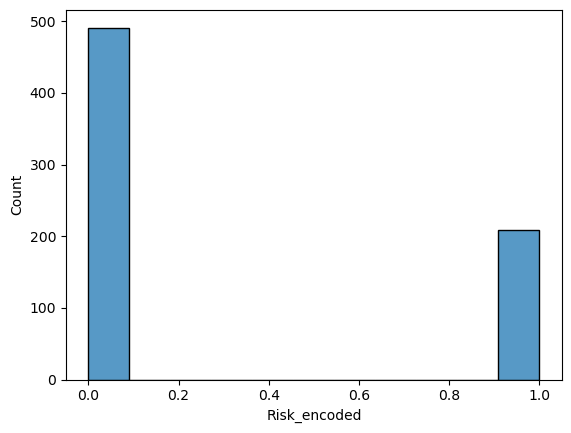

In [55]:
#Plotting the distribution of y train first 
sns.histplot(y_train)

Since we have lower number of class 1 (Bad Risk) observation in training data set we increase quantity of them through SMOTE 

In [56]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='Risk_encoded', ylabel='Count'>

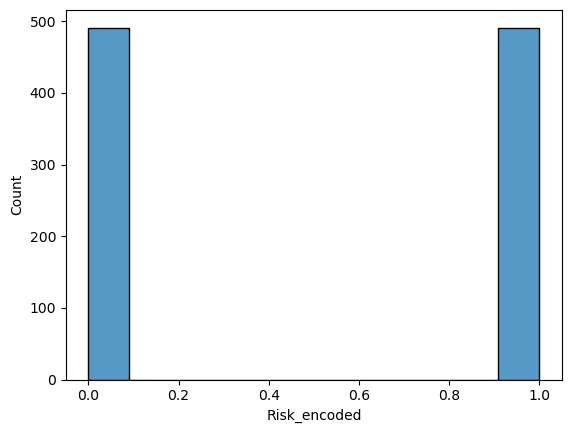

In [57]:
sns.histplot(y_train)

### Logistic Regression

In [58]:
# Perform feature selection (e.g., using SelectFromModel with L1 regularization)
# Example using Logistic Regression with L1 regularization for feature selection
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
selector = SelectFromModel(logreg)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Example parameter grid
grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Model training and prediction
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

# Evaluate model performance
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)



Selected Features: Index(['Age', 'Job', 'Credit amount', 'Duration', 'sex_encoded', 'Housing_own',
       'Housing_rent', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Saving accounts_encoded',
       'Checking account_encoded'],
      dtype='object')

Best Parameters: {'C': 100}

Confusion Matrix:
[[134  75]
 [ 44  47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       209
           1       0.39      0.52      0.44        91

    accuracy                           0.60       300
   macro avg       0.57      0.58      0.57       300
weighted avg       0.64      0.60      0.62       300



### Decision Tree

In [59]:
# Perform feature selection (e.g., using SelectFromModel with DecisionTreeClassifier)
# Example using Decision Tree for feature selection
dt = DecisionTreeClassifier(random_state=42)
selector = SelectFromModel(dt)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Hyperparameter tuning using GridSearchCV
param_grid = {'max_depth': [None, 10, 20, 30, 40, 50]}  # Example parameter grid
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Model training and prediction
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

# Evaluate model performance
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Selected Features: Index(['Age', 'Credit amount', 'Duration'], dtype='object')

Best Parameters: {'max_depth': 10}

Confusion Matrix:
[[127  82]
 [ 60  31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       209
           1       0.27      0.34      0.30        91

    accuracy                           0.53       300
   macro avg       0.48      0.47      0.47       300
weighted avg       0.56      0.53      0.54       300



### XGB Classiifer

In [60]:

# Perform feature selection (e.g., using SelectFromModel with XGBClassifier)
# Example using XGBoost for feature selection
xgb = XGBClassifier(random_state=42)
selector = SelectFromModel(xgb)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}  # Example parameter grid
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Model training and prediction
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

# Evaluate model performance
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Selected Features: Index(['Age', 'Job', 'Duration', 'Housing_own', 'Purpose_car',
       'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Saving accounts_encoded'],
      dtype='object')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Confusion Matrix:
[[152  57]
 [ 58  33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       209
           1       0.37      0.36      0.36        91

    accuracy                           0.62       300
   macro avg       0.55      0.54      0.55       300
weighted avg       0.62      0.62      0.62       300



### Random Forest Classifer

In [61]:
# Perform feature selection (e.g., using SelectFromModel with RandomForestClassifier)
# Example using Random Forest for feature selection
rf = RandomForestClassifier(random_state=42)
selector = SelectFromModel(rf)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200,300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}  # Example parameter grid
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Model training and prediction
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

# Evaluate model performance
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Selected Features: Index(['Age', 'Credit amount', 'Duration'], dtype='object')

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Confusion Matrix:
[[155  54]
 [ 56  35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       209
           1       0.39      0.38      0.39        91

    accuracy                           0.63       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.63      0.63      0.63       300



### Linear Discriminant Analysis

In [62]:
# Perform feature selection (e.g., using SelectFromModel with LinearDiscriminantAnalysis)
# Example using LDA for feature selection
lda = LinearDiscriminantAnalysis()
selector = SelectFromModel(lda)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Hyperparameter tuning using GridSearchCV (LDA does not have hyperparameters to tune)
# However, we can still use GridSearchCV for consistency
param_grid = {}  # No hyperparameters for LDA
grid_search = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=10)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_

# Model training and prediction
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

# Evaluate model performance
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Selected Features: Index(['Age', 'Duration', 'Housing_own', 'Housing_rent',
       'Purpose_domestic appliances', 'Purpose_furniture/equipment',
       'Purpose_radio/TV', 'Purpose_repairs'],
      dtype='object')

Confusion Matrix:
[[137  72]
 [ 47  44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       209
           1       0.38      0.48      0.43        91

    accuracy                           0.60       300
   macro avg       0.56      0.57      0.56       300
weighted avg       0.63      0.60      0.61       300



In [76]:
# Create a pipeline with feature selection and Naive Bayes model
pipeline = Pipeline([
    ('feature_selection', SelectKBest()),
    ('naive_bayes', GaussianNB())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
    'naive_bayes__var_smoothing': np.logspace(0, -9, num=100)  # Parameter for Naive Bayes
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters found: {'feature_selection__k': 3, 'naive_bayes__var_smoothing': 0.004328761281083057}
Best cross-validation accuracy: 0.6243136848648089
Confusion Matrix:
[[ 91 118]
 [ 27  64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.44      0.56       209
           1       0.35      0.70      0.47        91

    accuracy                           0.52       300
   macro avg       0.56      0.57      0.51       300
weighted avg       0.64      0.52      0.53       300

Accuracy: 0.52


In [79]:
# Create a pipeline with feature selection and KNN model
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weight function
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters found: {'feature_selection__k': 1, 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best cross-validation accuracy: 0.7101160261058739
Confusion Matrix:
[[206   3]
 [ 88   3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       209
           1       0.50      0.03      0.06        91

    accuracy                           0.70       300
   macro avg       0.60      0.51      0.44       300
weighted avg       0.64      0.70      0.59       300

Accuracy: 0.70


## Logic Behing choosing the best model

##### Clearly Banks prefer taking lower risk than making high profit, Thus higher recall score for Class 1 observation which is the Risky loan class is a better metric than accuracy , hence we choose the model with the highest Recall number for Class 1 / Risky loan observation

#### Thus Naive Bayes classifier is the best model with 70% Recall rate which indicates of all bad loans made , 70 % of them have been correctly specified respectively

###### Future things to add 
- ROC Curve of Naive Bayes Classifier 
- Feature Importance and Feature selection 
- All the metrics of all the model in a common Dataframe for easier comparison
- Parameters for increasing accuracy score

                                                                           ~  Devjit Ghosh